# Introduction
This is modified a notebook version of the TFT model script written in TF2 folder. This works with both the old and new dataset.If you are switching dataset, be sure to change both input csv and `config.json` files. They can be found in the `TF2\Notebooks\2022_May` or `TF2\Notebooks\2021_Nov` folder.  This notebook used the input files in `TF2\Notebooks\2022_May` folder. You can recreate them using the `Data preparation` notebook in this same folder. For a fresh model training, remove any files from the `checkpoint` folder.

It is modified to run on colab. If you want to run on your local machine, you can use the model scripts in the TF2 folder instead. Run the model on GPU or reduce `epochs` in `config.json`.

The input dataset is splitted into three parts here based on the following dates

* `Train`: From `2020-02-28` to `2021-11-22`
* `Validation`: From `2021-11-23` to `2022-02-18`
* `Test`: From `2022-02-19` to `2022-05-17`

# Initial Setup
## Importing libraries

In [1]:
import tensorflow as tf
import os, gc, json
import pandas as pd
from pandas import to_datetime

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Apply the default theme
sns.set_theme()
sns.set(font_scale = 1.5)

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Run the following if cuda is out of memory

In [3]:
import torch
gc.collect()
torch.cuda.empty_cache()

## Adding google drive
Set `running_on_colab= True` if running on Google colab.

In [3]:
running_on_colab = False

if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/My Drive/Projects/Covid/v0/notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Projects/Covid/v0/notebooks


## Setting up folders
The current folder has the following structure

* 2022_May
  * Population_cut.csv
  * Total.csv
  * Rurality_cut.csv
* config_2022_May.json
* output
  * checkpoints
  * figures

## For new dataset
You can collect either of the csv files for new dataset is in the `TF2\Notebooks\2022_May` folder. 

## For the old dataset 
Collect the csv files from the `TF2\Notebooks\2021_Nov` folder. 

In [4]:
from dataclasses import dataclass

@dataclass
class args:
    # folder where the cleaned feature file are at
    dataPath = '../2022_May/Population_cut.csv'

    outputPath = '../output/'
    configPath = '../config_2022_May.json'
    checkpoint = os.path.join(outputPath, 'checkpoints')
    restore = False

In [5]:
# output paths
checkpoint_folder = args.checkpoint
figure_folder = os.path.join(args.outputPath, "figures")

# this eventually creates output folder if it doesn't exist
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder, exist_ok=True)

if not os.path.exists(figure_folder):
    os.makedirs(figure_folder, exist_ok=True)

In [6]:
print(f'Loading config.json from {args.configPath}')
with open(args.configPath) as inputfile:
    config = json.load(inputfile)
    inputfile.close()

Loading config.json from ../config_2022_May.json


## Import local modules

In [7]:
import sys
sys.path.append( '..' )
from script.utils import train_validation_test_split, scale_back, calculate_result, sumCases
from Class.Trainer import Trainer
from Class.ParameterManager import ParameterManager
from Class.DataProcessor import DataProcessor
from Class.Plotter import PlotResults, PlotWeights

## Load data

In [8]:
print(f'Loading input data from {args.dataPath}')
df = pd.read_csv(args.dataPath)
print(f'Input feature file shape {df.shape}')

Loading input data from ../2022_May/Population_cut.csv
Input feature file shape (81000, 20)


In [9]:
df['Date'] = to_datetime(df['Date']) 
df['FIPS'] = df['FIPS'].astype(str)

# Pre-processing

## Parameter manager

In [10]:
parameterManager = ParameterManager(config)
print(f'Column mappings: {parameterManager.col_mappings}\n')

Column mappings: {'Static': ['AgeDist', 'AirPollution', 'HealthDisp'], 'ID': ['FIPS'], 'Time': ['TimeFromStart'], 'Target': ['Cases'], 'Future': ['LinearSpace', 'Constant', 'LinearTime', 'P2Time', 'P3Time', 'P4Time', 'CosWeekly', 'SinWeekly'], 'Known Regular': ['AgeDist', 'AirPollution', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']}



## Train validation test split and Scaling

In [11]:
train_data, validation_data, test_data, target_scaler = train_validation_test_split(df, parameterManager, scale=True)
print(f'Number train data is {train_data.shape[0]}, validation {validation_data.shape[0]}, test {test_data.shape[0]}')

Number train data is 63400, validation 8800, test 8800


## Create batches

In [12]:
dataProcessor = DataProcessor(
    parameterManager.total_sequence_length, parameterManager.col_mappings, parameterManager.data_params
)

train_batch = dataProcessor.prepare_batch(train_data, train=True)
validation_batch = dataProcessor.prepare_batch(validation_data)

gc.collect()

0

# Training

## Util

In [13]:
def plot_history(history:dict,  figure_path:str=None, show=False):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharex=True)
    x = range(1, len(history['train_loss'])+1)

    # label_text   = [f'{int(loc/1000)}k' for loc in plt.yticks()[0]]
    # ax.set_yticklabels(label_text)

    ax[0].set_title('Training history')
    ax[0].plot(x, history['train_loss'], color='blue', label='Train loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Squared Error of daily covid cases')
    ax[0].legend()

    ax[1].set_title('Validation history')
    ax[1].plot(x, history['validation_loss'], color='green', label='Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Squared Error of daily covid cases')
    ax[1].legend()

    fig.tight_layout()
    if figure_path:
        plt.savefig(figure_path)
    if show:
        plt.show()

## Create Trainer

In [14]:
trainer = Trainer(parameterManager, disable_progress=False)
model = trainer.create_model()

## Optimizer and Checkpoint

In [15]:
optimizer_params = parameterManager.optimizer_params
optimizer = tf.keras.optimizers.Adam(
    learning_rate=optimizer_params['learning_rate'], clipnorm=optimizer_params['clipnorm']
)

checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
checkpointManager = tf.train.CheckpointManager(checkpoint, checkpoint_folder, max_to_keep=1)

In [16]:
if args.restore and checkpointManager.latest_checkpoint:
    model = trainer.load_from_checkpoint(checkpoint, checkpointManager.latest_checkpoint)
    if model is None:
        sys.exit(-1)

## Training loop

In [17]:
# parameterManager.epochs = 2
history = trainer.fit(
    model, optimizer, train_batch, validation_batch, checkpointManager, early_stopping_patience=parameterManager.early_stopping_patience
)

Running the model for 5 epochs.
Epoch 1


Train:   0%|          | 0/949 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train loss 0.0141141, time 0:01:55.710818. Validation loss 0.0142514, time 0:00:10.298070
Loss improved from inf to 0.0142514

Saving checkpoint for epoch 1 at ../output/checkpoints/ckpt-1
Epoch 2


Train:   0%|          | 0/949 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train loss 0.00249897, time 0:01:10.290316. Validation loss 0.0136544, time 0:00:02.018708
Loss improved from 0.0142514 to 0.0136544

Saving checkpoint for epoch 2 at ../output/checkpoints/ckpt-2
Epoch 3


Train:   0%|          | 0/949 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train loss 0.00246531, time 0:01:09.387197. Validation loss 0.017156, time 0:00:01.864307
Early stop counter 1/3
Epoch 4


Train:   0%|          | 0/949 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train loss 0.00243778, time 0:01:08.593668. Validation loss 0.0156856, time 0:00:01.833551
Early stop counter 2/3
Epoch 5


Train:   0%|          | 0/949 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train loss 0.00234233, time 0:01:10.699600. Validation loss 0.0133825, time 0:00:01.890204
Loss improved from 0.0136544 to 0.0133825

Saving checkpoint for epoch 5 at ../output/checkpoints/ckpt-3


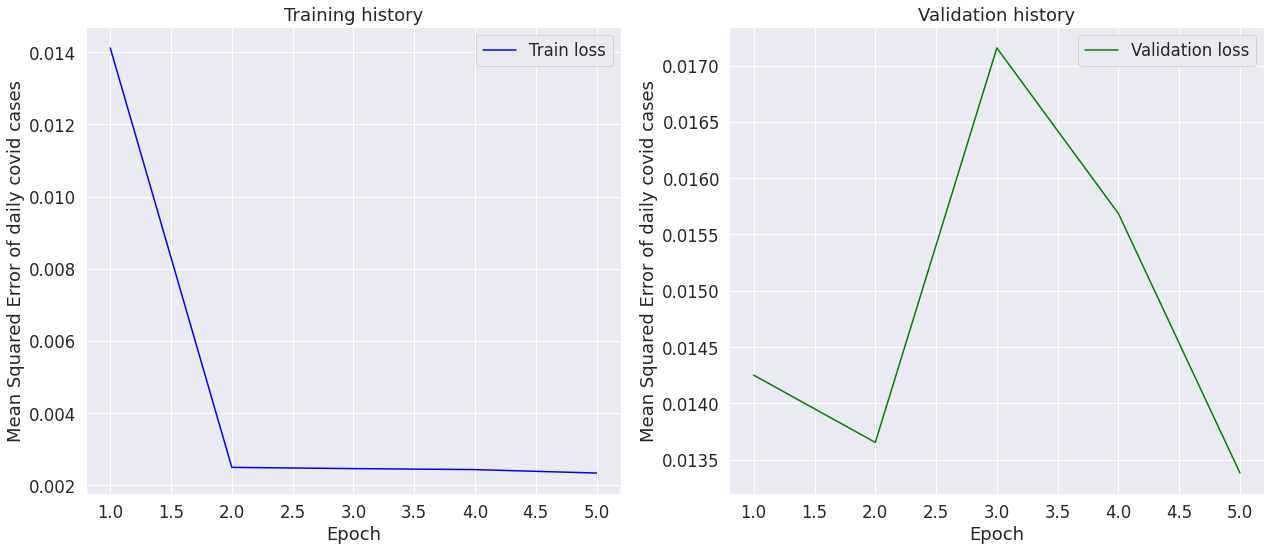

5437

In [18]:
plot_history(history, os.path.join(figure_folder, 'history.png'), show=True)
gc.collect()

## Testing

In [19]:
# load the best checkpoint by validation loss
model = trainer.load_from_checkpoint(checkpoint, checkpointManager.latest_checkpoint)
if model is None:
    sys.exit(-1)

Checkpoint restored from ../output/checkpoints/ckpt-3


### Train predictions

In [20]:
train_batch = dataProcessor.prepare_batch(train_data)
train_preds, train_actuals, train_attn_weights = trainer.predict(model, train_batch)

train_actuals = scale_back(train_actuals, target_scaler, parameterManager.target_sequence_length)
train_preds = scale_back(train_preds, target_scaler, parameterManager.target_sequence_length)

train_mae, train_rmse, train_smape = calculate_result(train_actuals, train_preds)
print(f'Train MAE {train_mae}, RMSE {train_rmse}, SMAPE {train_smape}')
gc.collect()

  0%|          | 0/949 [00:00<?, ?it/s]

Train MAE 159.4506, RMSE 435.3345, SMAPE 0.7504


19

### Validation predictions

In [21]:
validation_preds, validation_actuals, _ = trainer.predict(model, validation_batch)

validation_preds = scale_back(validation_preds, target_scaler, parameterManager.target_sequence_length)
validation_actuals = scale_back(validation_actuals,  target_scaler, parameterManager.target_sequence_length)

validation_mae, validation_rmse, validation_smape = calculate_result(validation_actuals, validation_preds)
print(f'Validation MAE {validation_mae}, RMSE {validation_rmse}, SMAPE {validation_smape}')

  0%|          | 0/96 [00:00<?, ?it/s]

Validation MAE 609.6945, RMSE 1292.1435, SMAPE 1.2155


### Test

In [22]:
test_batch = dataProcessor.prepare_batch(test_data)
test_preds, test_actuals, _ = trainer.predict(model, test_batch)

test_actuals = scale_back(test_actuals, target_scaler, parameterManager.target_sequence_length) 
test_preds = scale_back(test_preds, target_scaler, parameterManager.target_sequence_length)

test_mae, test_rmse, test_smape = calculate_result(test_actuals, test_preds)
print(f'Test MAE {test_mae}, RMSE {test_rmse}, SMAPE {test_smape}')

  0%|          | 0/96 [00:00<?, ?it/s]

Test MAE 196.5363, RMSE 435.5287, SMAPE 1.2857


### Delete model

In [23]:
del model
gc.collect()

90

# Result plot

In [24]:
number_of_locations = df[parameterManager.col_mappings['ID']].nunique().values[0]
print(f'Number of locations {number_of_locations}')
locs = df[parameterManager.col_mappings['ID']].iloc[:number_of_locations, 0].values

Number of locations 100


## Train

Saving ../output/figures/Summed plot - train.png


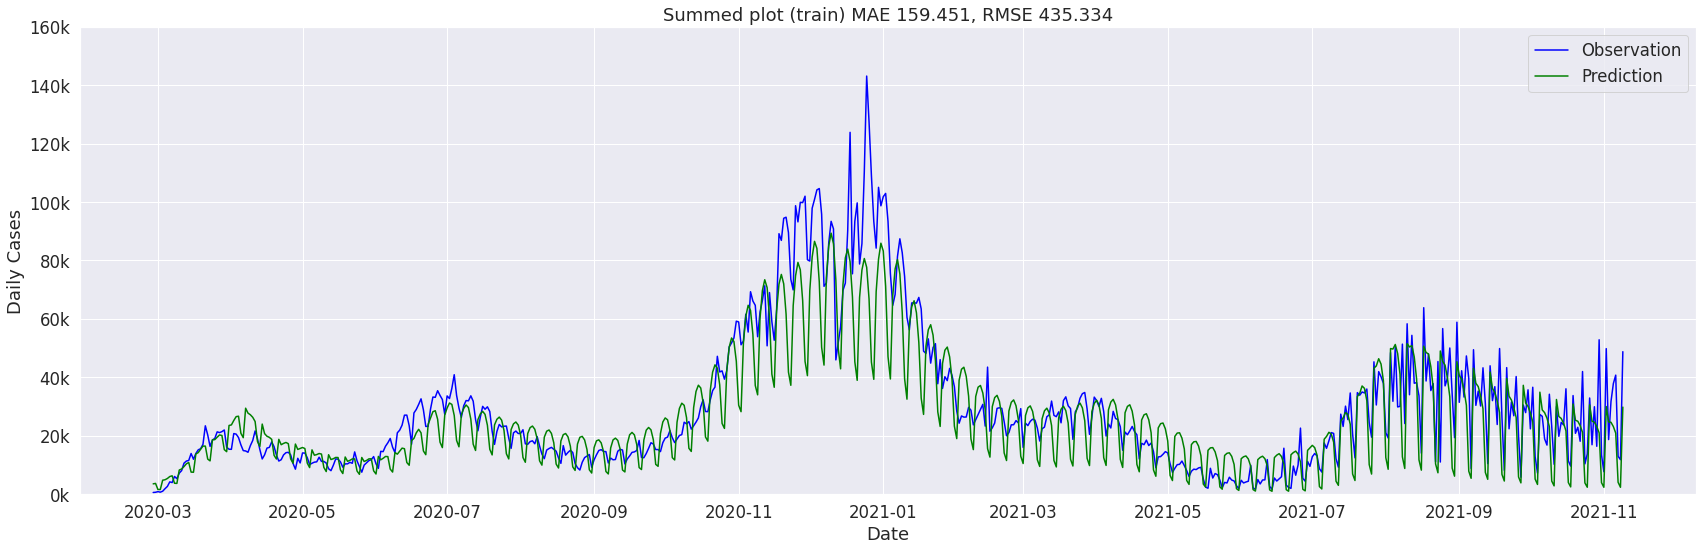

In [25]:
targets, predictions = sumCases(train_actuals, train_preds, number_of_locations)

resultPlotter = PlotResults(targets, predictions, parameterManager.train_start, locs, figure_folder)
plot_title = f'Summed plot (train) MAE {train_mae:0.3f}, RMSE {train_rmse:0.3f}'

resultPlotter.makeSummedPlot(plot_title, figure_name='Summed plot - train', figsize=(24, 8))

## Validation

Saving ../output/figures/Summed plot - validation.png


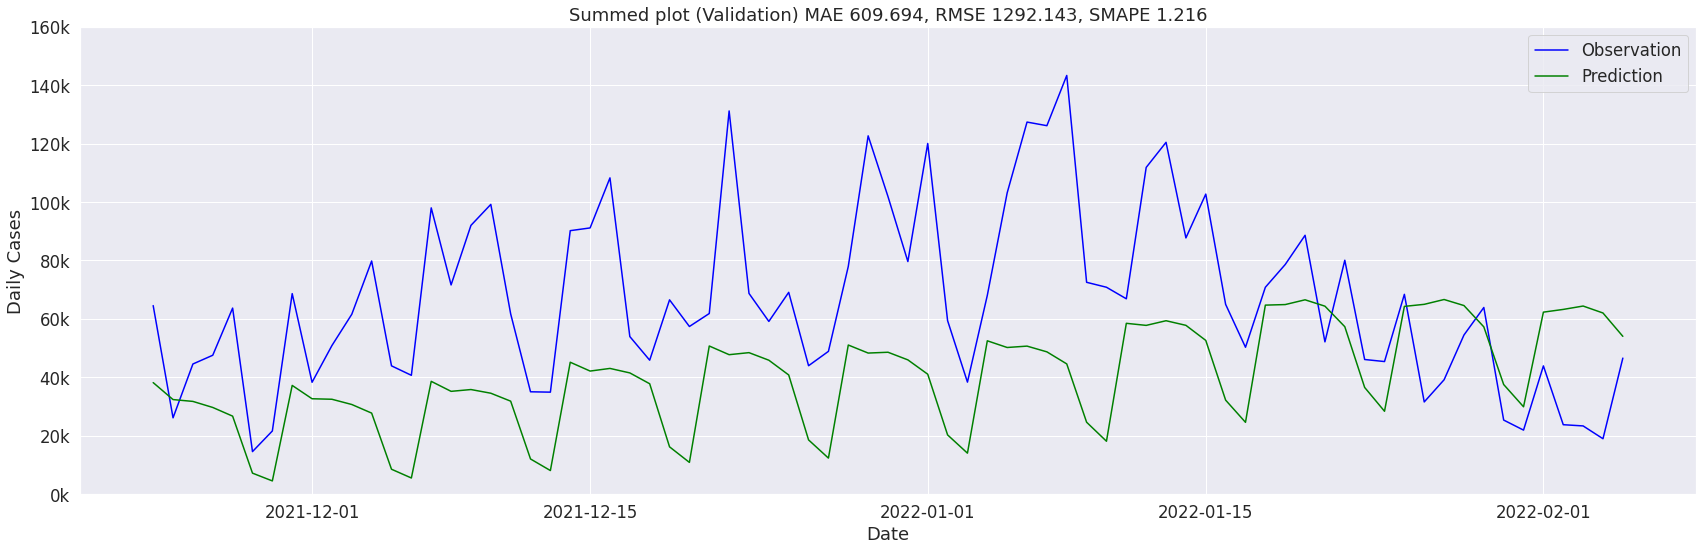

In [26]:
targets, predictions = sumCases(validation_actuals, validation_preds, number_of_locations)
resultPlotter = PlotResults(targets, predictions, parameterManager.validation_start, locs, figure_folder)
plot_title = f'Summed plot (Validation) MAE {validation_mae:0.3f}, RMSE {validation_rmse:0.3f}, SMAPE {validation_smape:0.3f}'

resultPlotter.makeSummedPlot(plot_title, figure_name='Summed plot - validation')

## Test

Saving ../output/figures/Summed plot - test.png


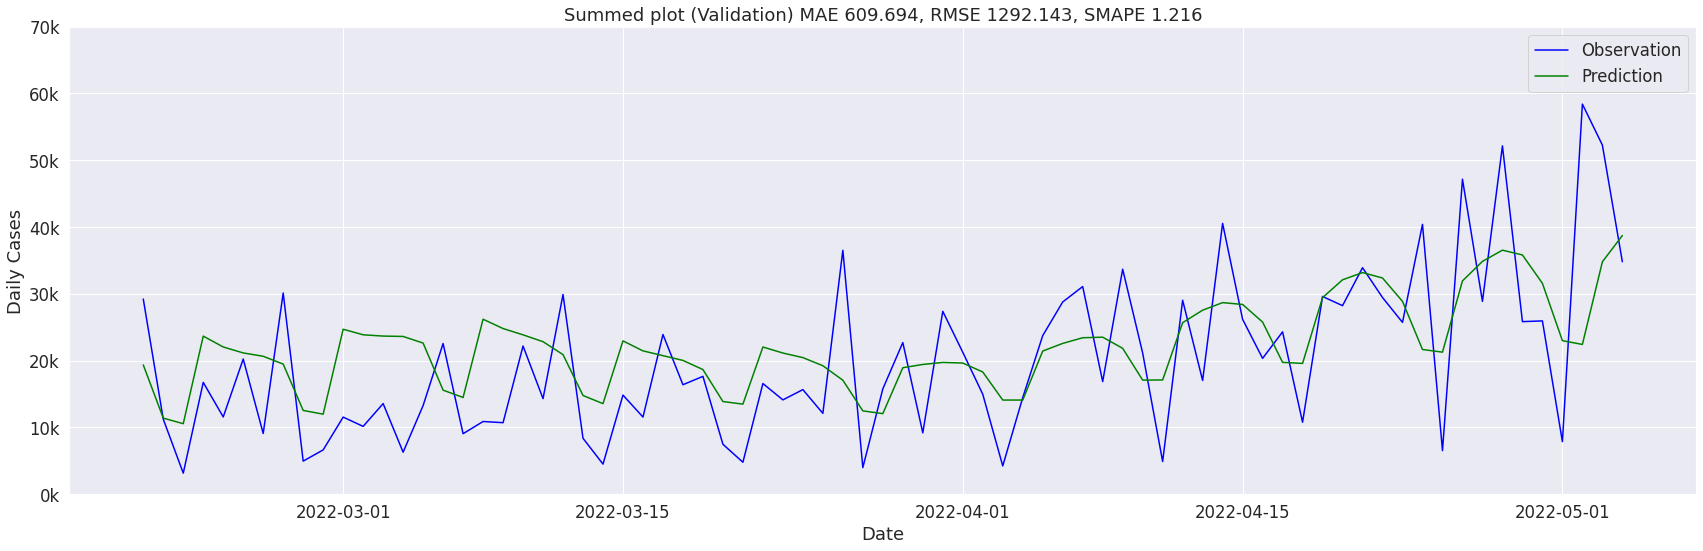

In [27]:
targets, predictions = sumCases(test_actuals, test_preds, number_of_locations)
PlotC = PlotResults(targets, predictions, parameterManager.test_start, locs, figure_folder)
plot_title = f'Summed plot (Validation) MAE {validation_mae:0.3f}, RMSE {validation_rmse:0.3f}, SMAPE {validation_smape:0.3f}'

PlotC.makeSummedPlot(plot_title, figure_name='Summed plot - test')

# Interpret

Saving ../output/figures/Static input selection weights by variable.png


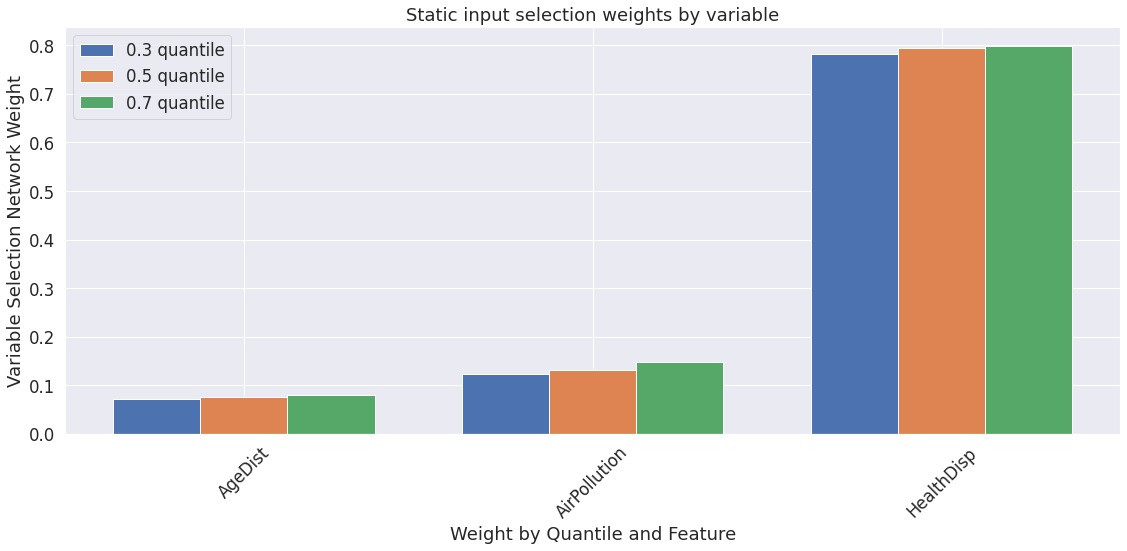

Saving ../output/figures/Future known input selection weights by variable.png


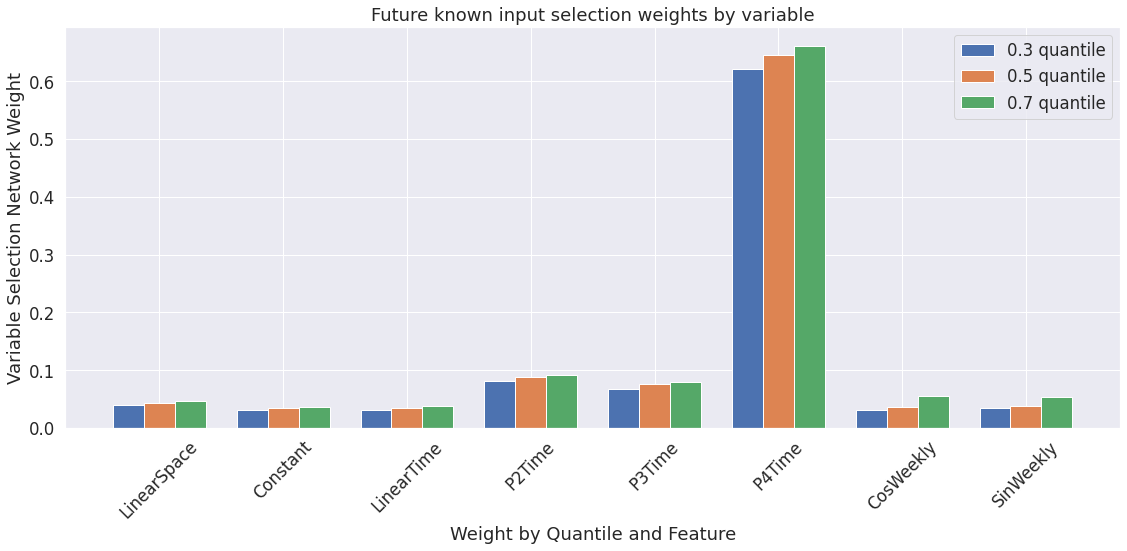

Saving ../output/figures/Observed input selection weights by variable.png


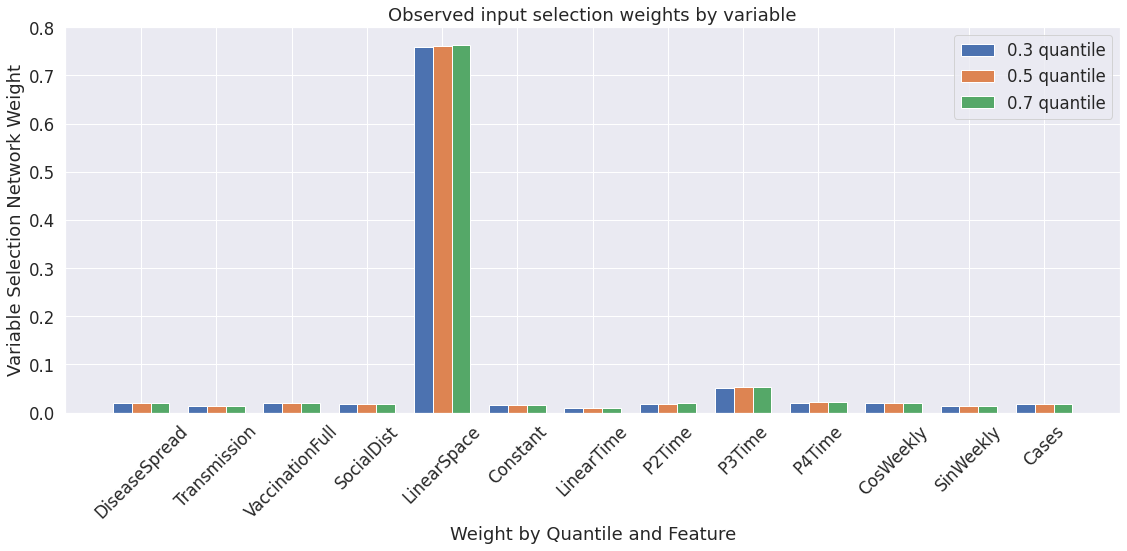

In [28]:
plotter = PlotWeights(parameterManager.col_mappings, train_attn_weights, figure_folder, show=True)
"""## Static variables"""

plotter.plot_static_weights()

"""## Future known input"""

plotter.plot_future_weights()

"""## Observed weights"""

plotter.plotObservedWeights()